# 1. Data Exploration and feature extraction

From the documentation we see that:
"The input images are expected to have color values in the range [0,1], following the common image input conventions. For this model, the size of the input images is fixed to height x width = 224 x 224 pixels."

## Loading Image Dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and scaling
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)  # Adjust rescaling if needed
print('Training set:')
trainset = datagen.flow_from_directory('./train', target_size=image_size, batch_size=batch_size)
print('Validation set:')
validset = datagen.flow_from_directory('./valid', target_size=image_size, batch_size=batch_size)
print('Testing set:')
testset = datagen.flow_from_directory('./test', target_size=image_size, batch_size=batch_size)


2024-11-11 23:15:07.511245: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-11 23:15:07.511293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training set:
Found 280 images belonging to 6 classes.
Validation set:
Found 139 images belonging to 6 classes.
Testing set:
Found 50 images belonging to 6 classes.


In [3]:
class_labels = list(validset.class_indices.keys())
class_labels

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

## Plotting of few images

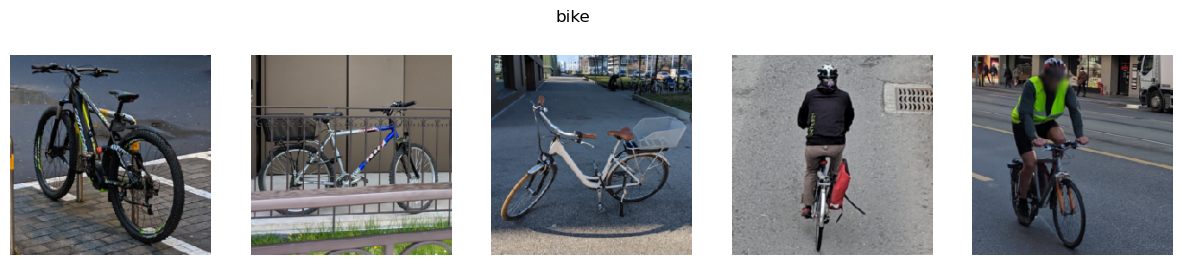

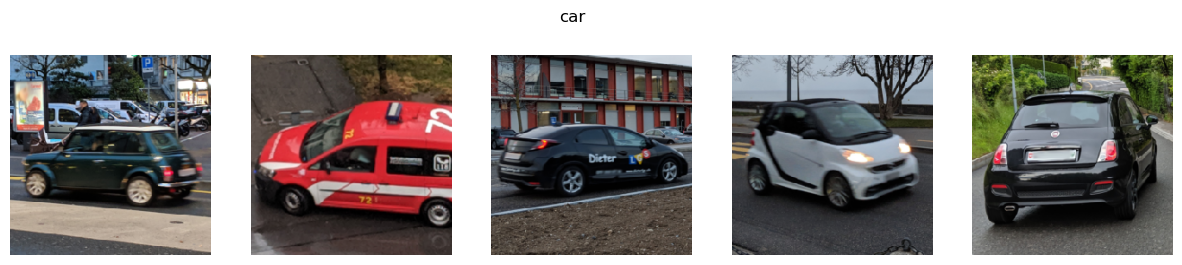

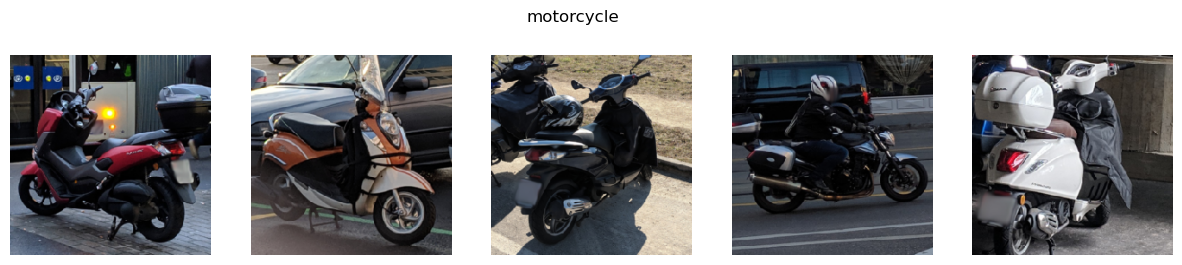

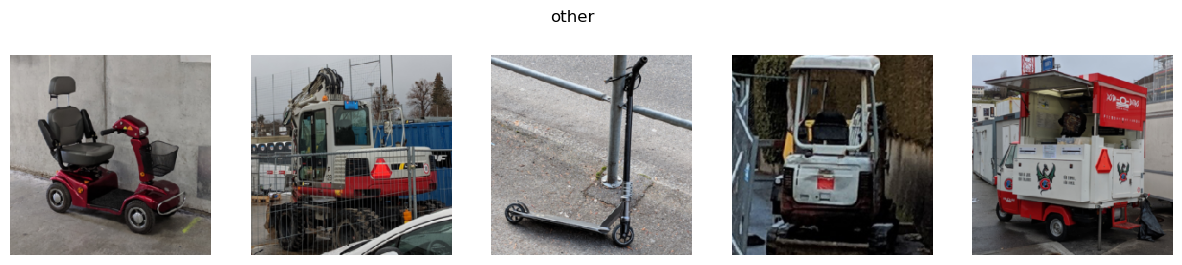

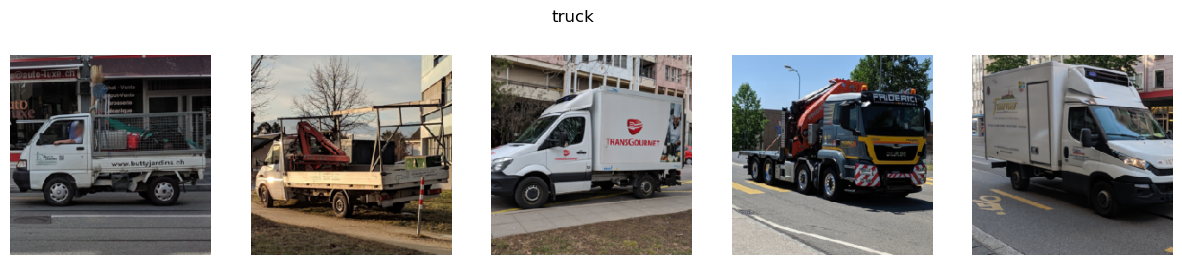

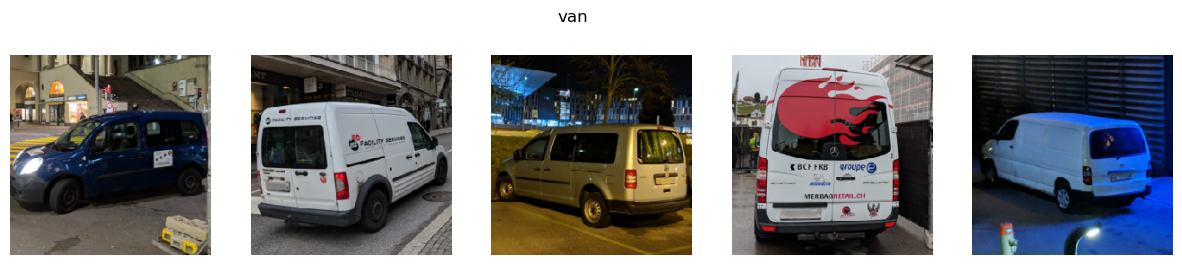

In [4]:
import matplotlib.pyplot as plt

def plot_samples(data, category):
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(category)
    
    k=0
    while k<5:

        images, labels = next(iter(data))
    
        for n,label in enumerate(labels):
            if label[class_labels.index(category)] == 1:
                axes[k].imshow(images[n]) 
                axes[k].axis('off')
                k+=1
                if k==5:
                    break

for category in class_labels:
    plot_samples(trainset, category)


## Category distributions

(0.0, 0.25)

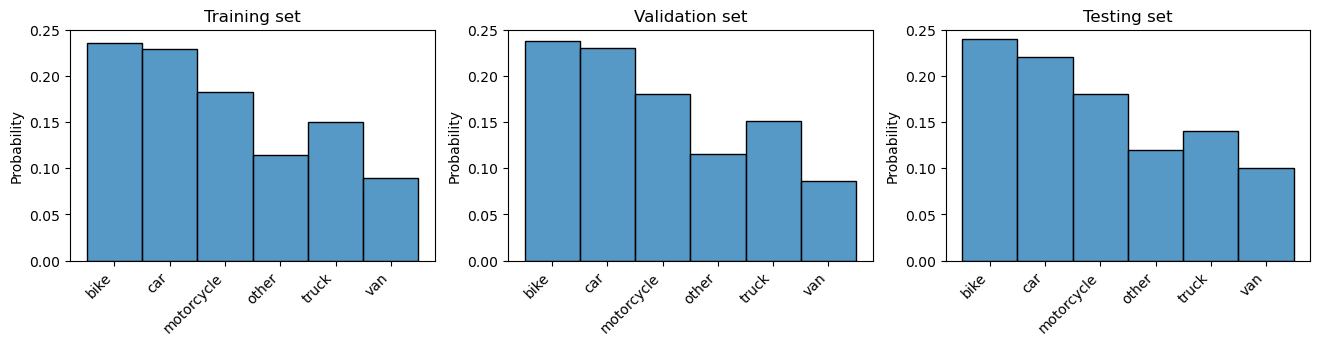

In [5]:
import seaborn as sns
import numpy as np

class_dist = {'test': testset.classes, 'valid': validset.classes,'train': trainset.classes}


fig, axes = plt.subplots(1, 3, figsize=(16, 3))

sns.histplot(trainset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[0])
axes[0].set_title('Training set')
axes[0].set_xticks(np.arange(len(class_labels))+0.5)
axes[0].set_xticklabels(class_labels, rotation=45, ha='right')
axes[0].set_ylim(0,0.25)

sns.histplot(validset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[1])
axes[1].set_title('Validation set')
axes[1].set_xticks(np.arange(len(class_labels))+0.5)
axes[1].set_xticklabels(class_labels, rotation=45, ha='right')
axes[1].set_ylim(0,0.25)

sns.histplot(testset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[2])
axes[2].set_title('Testing set')
axes[2].set_xticks(np.arange(len(class_labels))+0.5)
axes[2].set_xticklabels(class_labels, rotation=45, ha='right')
axes[2].set_ylim(0,0.25)

All three set have almost identical class distribution.

## Training Set total color histogram

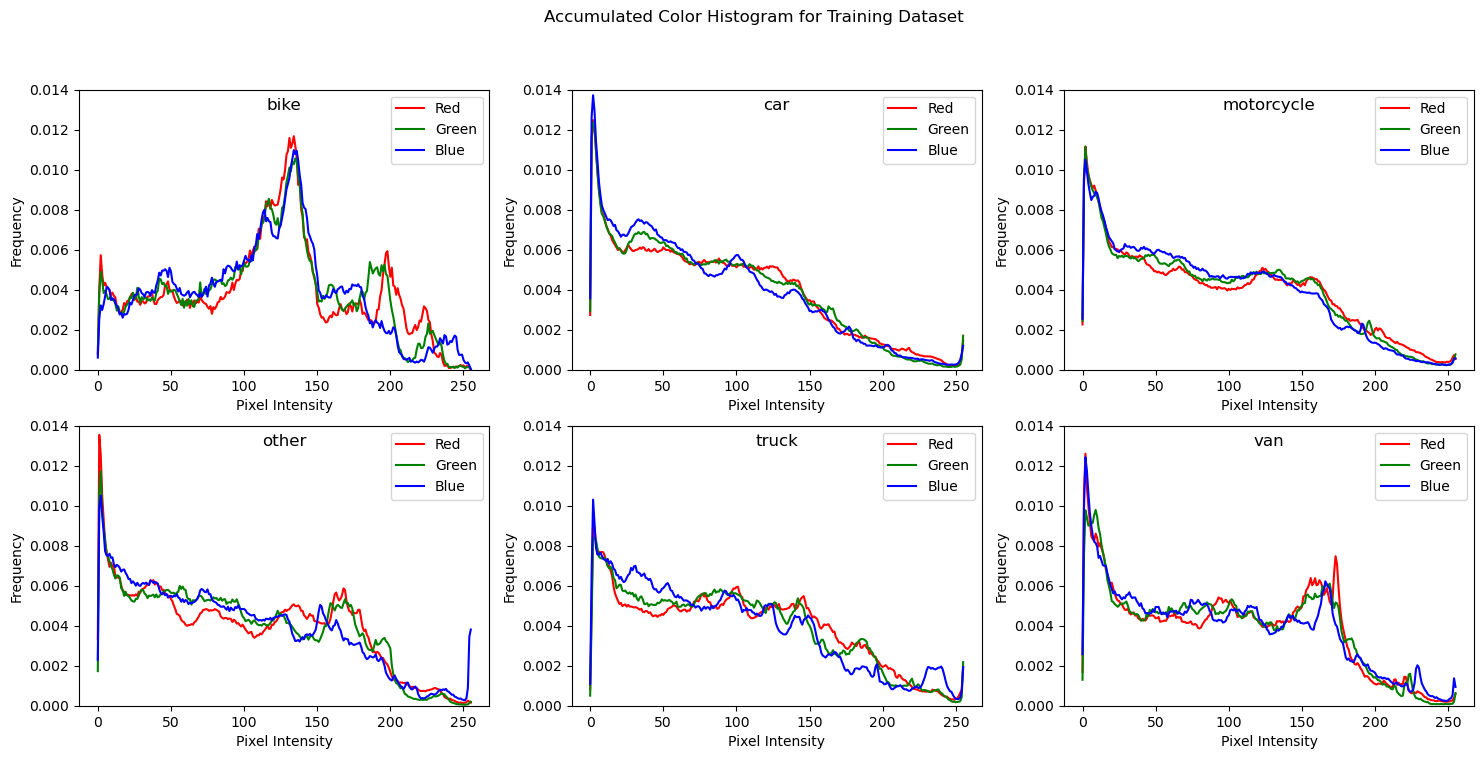

In [6]:
def plot_histograms(data, category):

    hist_r_total = np.zeros(256)
    hist_g_total = np.zeros(256)
    hist_b_total = np.zeros(256)

    while True:
        images, labels = next(iter(data))
        for n,label in enumerate(labels):
            if label[class_labels.index(category)] == 1:

                # Calculate histograms for each channel (R, G, B) separately
                hist_r, _ = np.histogram(images[n, :, :, 0].ravel()*256, bins=256, range=(0, 256))
                hist_g, _ = np.histogram(images[n, :, :, 1].ravel()*256, bins=256, range=(0, 256))
                hist_b, _ = np.histogram(images[n, :, :, 2].ravel()*256, bins=256, range=(0, 256))
                
                # Accumulate histograms
                hist_r_total += hist_r
                hist_g_total += hist_g
                hist_b_total += hist_b

        if len(labels) < 32:
            break

    # Normalize histograms if desired (optional)
    hist_r_total /= hist_r_total.sum()
    hist_g_total /= hist_g_total.sum()
    hist_b_total /= hist_b_total.sum()

    return hist_r_total, hist_g_total, hist_b_total

# Plot the accumulated color histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.ravel()
fig.suptitle('Accumulated Color Histogram for Training Dataset')

for k, category in enumerate(class_labels):
    
    hist_r_total, hist_g_total, hist_b_total = plot_histograms(trainset, category)

    axes[k].plot(hist_r_total, color='red', label='Red')
    axes[k].plot(hist_g_total, color='green', label='Green')
    axes[k].plot(hist_b_total, color='blue', label='Blue')

    axes[k].set_title(category, y=0.9)
    axes[k].set_xlabel('Pixel Intensity')
    axes[k].set_ylabel('Frequency')
    axes[k].set_ylim(0,0.014)
    axes[k].legend()

There are some structures/shapes that could hint at differentiate betweeen some groups of categories, but it would be almost impossible to differentiate the 6 categories with just the color informatiom. Additionally, here we observe the total mean of all images from a given category, but we don't have a view on the signal variance within each category. 

## Extract High-Level labels

Start by importing the model

In [7]:
import tensorflow_hub as hub

# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Two options:
# 1
feature_extractor = hub.load(model_url)
# 2
# feature_extractor = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

2024-11-11 23:15:21.043267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-11-11 23:15:21.043319: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-11-11 23:15:21.043382: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (TP-Carbon): /proc/driver/nvidia/version does not exist
2024-11-11 23:15:21.043662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Apply model to our dataset

In [20]:
def extract_features(dataset):
    
    features = tf.zeros((0, 1280))
    labels = tf.zeros((0, 6))
    
    while True:
        images_batch, labels_batch = next(iter(dataset))
        features = tf.concat([feature_extractor(images_batch), features], axis=0)
        labels = tf.concat([labels_batch, labels], axis=0)
        if len(labels_batch) < 32:
            break
            
    return features, labels

trainset_features, trainset_labels = extract_features(trainset)
validset_features, validset_labels = extract_features(validset)
testset_features, testset_labels = extract_features(testset)

print(f'Size of training set features: {trainset_features.shape}')
print(f'Size of validation set features: {validset_features.shape}')
print(f'Size of testing set features: {testset_features.shape}')

Size of training set features: (152, 1280)
Size of validation set features: (139, 1280)
Size of testing set features: (50, 1280)


Save computed features for all 3 datasets to numpy .npz file.

In [ ]:
# Save to an .npz file
np.savez('dataset_features.npz', 
         trainset_features=trainset_features.numpy(),
         validset_features=validset_features.numpy(),
         testset_features=testset_features.numpy(),
         trainset_labels=trainset_labels.numpy(),
         validset_labels=validset_labels.numpy(),
         testset_labels=testset_labels.numpy(),
         class_labels=class_labels       
         )

In [24]:
trainset_labels

<tf.Tensor: shape=(152, 6), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.

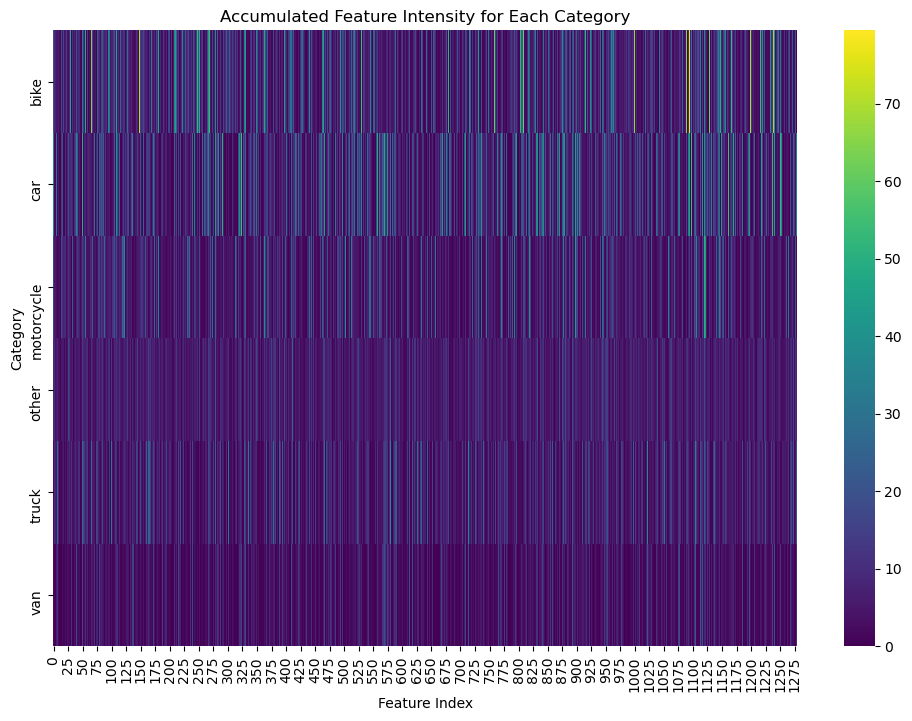

In [33]:
# Decode one-hot encoded labels to single integer labels
trainset_labels_decoded = np.argmax(trainset_labels, axis=1)

# Initialize a dictionary to store accumulated feature intensities
accumulated_features = {}

# Accumulate feature values for each category
for category_label, category_name in enumerate(class_labels):
    # Select features for the current category and sum them across all samples
    category_features = trainset_features.numpy()[trainset_labels_decoded == category_label]
    accumulated_features[category_name] = np.sum(category_features, axis=0)

# Plot heatmap for each category's accumulated features
plt.figure(figsize=(12, 8))
sns.heatmap([accumulated_features[category] for category in class_labels], 
            cmap='viridis', cbar=True, yticklabels=class_labels)
plt.title('Accumulated Feature Intensity for Each Category')
plt.xlabel('Feature Index')
plt.ylabel('Category')
plt.show()


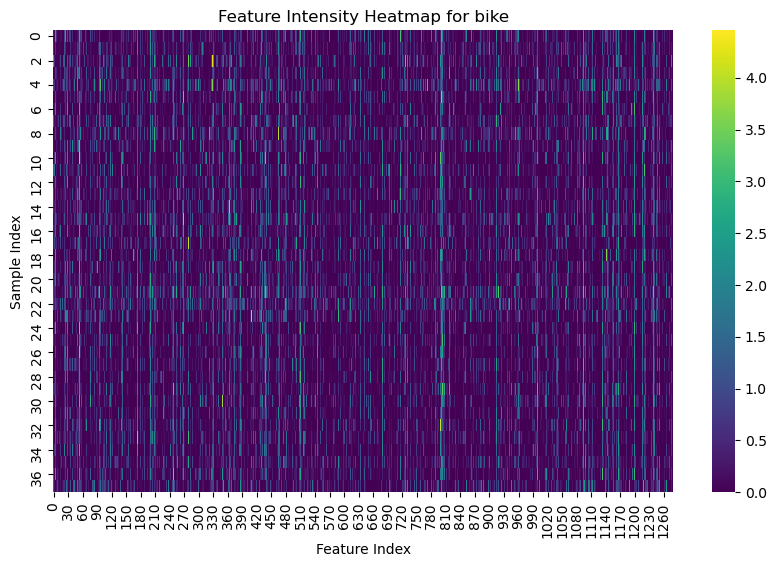

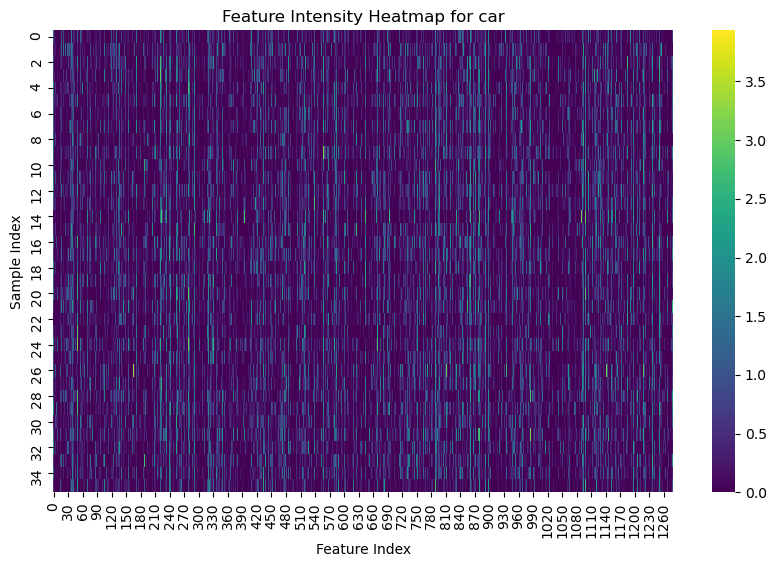

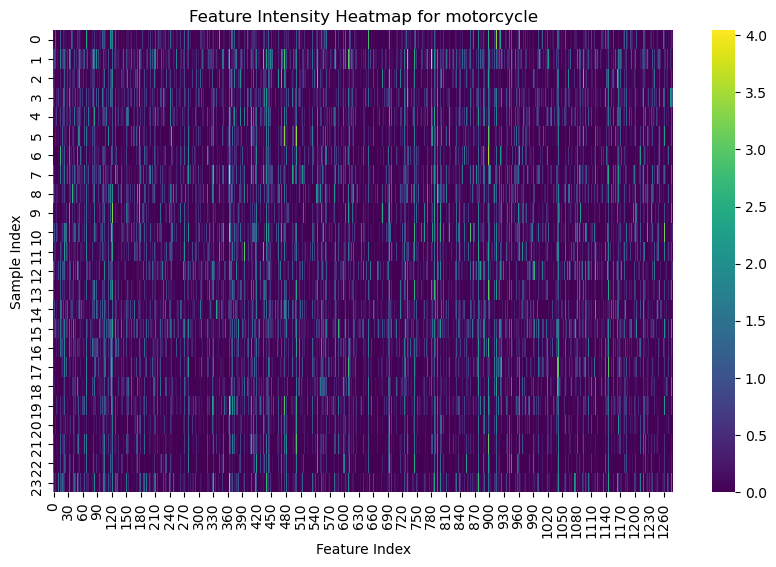

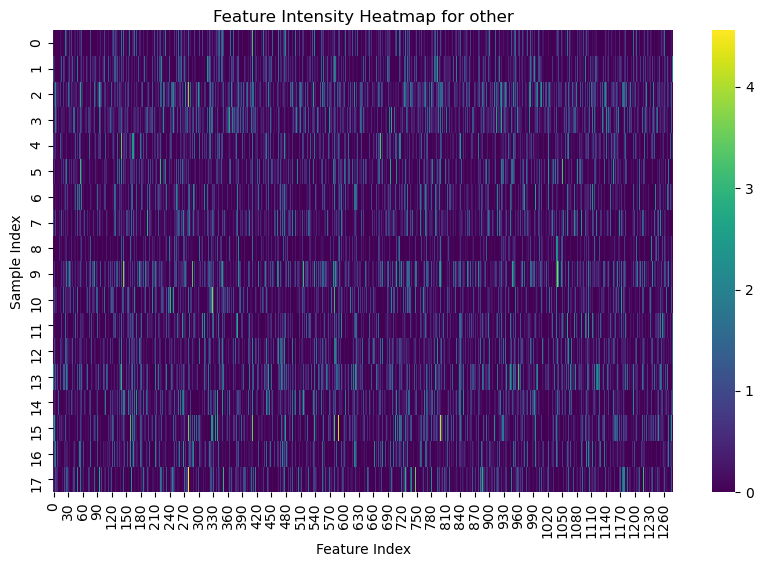

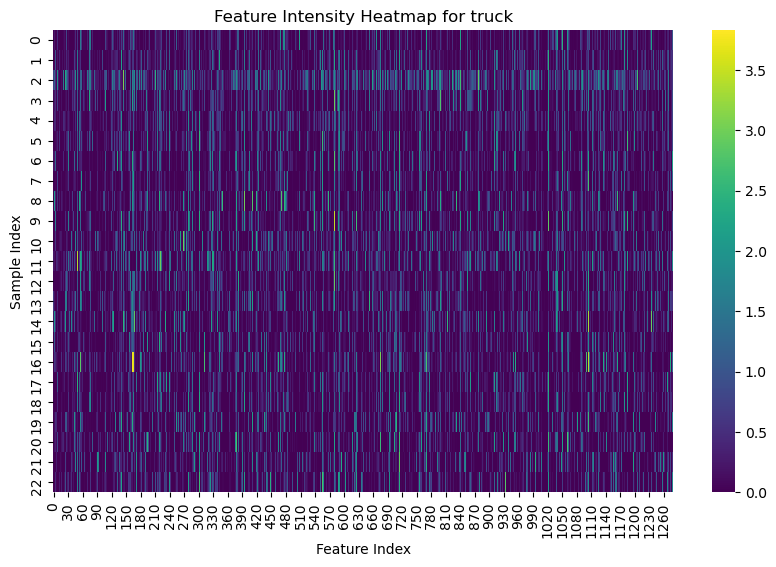

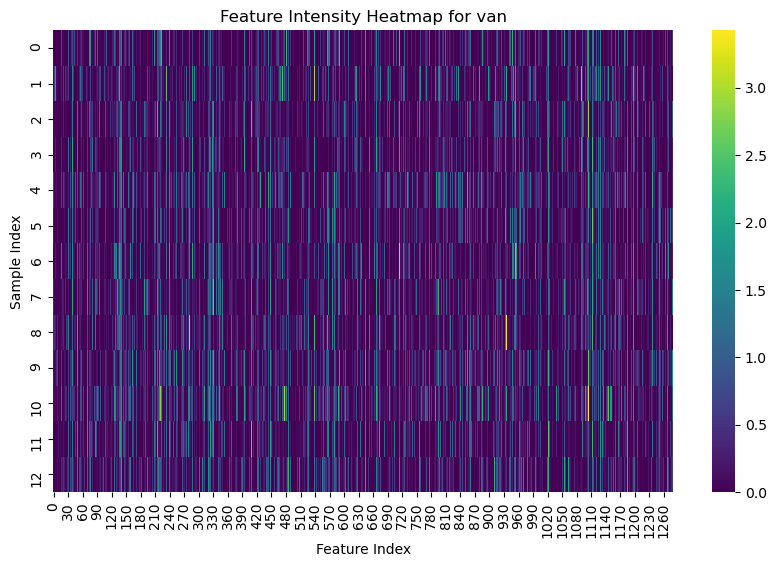

In [35]:
# Iterate over each category label
for category_label, category_name in enumerate(class_labels):
    # Select features for the current category
    category_features = trainset_features.numpy()[trainset_labels_decoded == category_label]
    
    # Check if there are samples in this category
    if category_features.size > 0:
        plt.figure(figsize=(10, 6))
        sns.heatmap(category_features, cmap='viridis', cbar=True)
        plt.title(f'Feature Intensity Heatmap for {category_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Sample Index')
        plt.show()

There seems to be a signature which is specific to each category. This could 

In [37]:
# Initialize a dictionary to store mean values for each category
category_top_features = {}

# Calculate mean feature values for each category and identify top 5 features
for category_label, category_name in enumerate(class_labels):
    # Select features for the current category
    category_features = trainset_features.numpy()[trainset_labels_decoded == category_label]
    
    # Calculate mean of each feature across all samples in the category
    feature_means = np.mean(category_features, axis=0)
    
    # Find top 5 features with the highest mean values
    top_5_indices = np.argsort(feature_means)[-5:][::-1]  # Indices of top 5 features
    top_5_features = [(idx, feature_means[idx]) for idx in top_5_indices]
    
    # Store top features in the dictionary
    category_top_features[category_name] = top_5_features

# Display the top 5 features for each category
for category, top_features in category_top_features.items():
    print(f"Top 5 features for {category}:")
    for feature_idx, mean_value in top_features:
        print(f"  Feature {feature_idx}: Mean Value = {mean_value}")
    print()

Top 5 features for bike:
  Feature 54: Mean Value = 2.092283248901367
  Feature 183: Mean Value = 2.0635321140289307
  Feature 1094: Mean Value = 2.062329053878784
  Feature 148: Mean Value = 1.8689968585968018
  Feature 1199: Mean Value = 1.8272696733474731

Top 5 features for car:
  Feature 257: Mean Value = 1.9306343793869019
  Feature 660: Mean Value = 1.8139089345932007
  Feature 183: Mean Value = 1.5933890342712402
  Feature 789: Mean Value = 1.5635273456573486
  Feature 861: Mean Value = 1.5572707653045654

Top 5 features for motorcycle:
  Feature 1120: Mean Value = 2.1020660400390625
  Feature 898: Mean Value = 1.8359389305114746
  Feature 1122: Mean Value = 1.8017829656600952
  Feature 505: Mean Value = 1.7539863586425781
  Feature 819: Mean Value = 1.6555320024490356

Top 5 features for other:
  Feature 411: Mean Value = 1.399788498878479
  Feature 580: Mean Value = 1.2854981422424316
  Feature 279: Mean Value = 1.220300316810608
  Feature 140: Mean Value = 1.184682846069336
